In [1]:
import random
import gym
#import math
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import warnings

warnings.filterwarnings(action='ignore')

In [2]:
EPOCHS = 1000
THRESHOLD = 45
MONITOR = True

In [3]:
class DQN():
    def __init__(self, env_string,batch_size=64):
        self.memory = deque(maxlen=100000)
        self.env = gym.make(env_string)
        input_size = self.env.observation_space.shape[0]
        action_size = self.env.action_space.n
        self.batch_size = batch_size
        self.gamma = 1.0
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        
        alpha=0.01
        alpha_decay=0.01
        
        if MONITOR: self.env = gym.wrappers.Monitor(self.env, '../data/'+env_string, force=True)
        
        self.model = Sequential()
        self.model.add(Dense(24, input_dim=input_size, activation='tanh'))
        self.model.add(Dense(48, activation='tanh'))
        self.model.add(Dense(action_size, activation='linear'))
        self.model.compile(loss='mse', optimizer=Adam(lr=alpha, decay=alpha_decay))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, epsilon):
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.model.predict(state))

    def preprocess_state(self, state):
        return np.reshape(state, [1, 4])

    def replay(self, batch_size):
        x_batch, y_batch = [], []
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            y_target = self.model.predict(state)
            y_target[0][action] = reward if done else reward + self.gamma * np.max(self.model.predict(next_state)[0])
            x_batch.append(state[0])
            y_batch.append(y_target[0])
        
        self.model.fit(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch), verbose=0)
        #epsilon = max(epsilon_min, epsilon_decay*epsilon) # decrease epsilon
       
    def train(self):
        scores = deque(maxlen=100)
        avg_scores = []
        
        for e in range(EPOCHS):
            state = self.env.reset()
            state = self.preprocess_state(state)
            done = False
            i = 0
            
            while not done:
                action = self.choose_action(state,self.epsilon)
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                self.epsilon = max(self.epsilon_min, self.epsilon_decay*self.epsilon)
                i += 1

            scores.append(i)
            mean_score = np.mean(scores)
            avg_scores.append(mean_score)
            
            if mean_score >= THRESHOLD and e >= 100:
                print('Ran {} episodes. Solved after {} trials ✔'.format(e, e - 100))
                return avg_scores
            
            if e % 100 == 0:
                print('[Episode {}] - Mean survival time over last 100 episodes was {} ticks.'.format(e, mean_score))

            self.replay(self.batch_size)
        
        print('Did not solve after {} episodes 😞'.format(e))
        return avg_scores

In [4]:
env_string = 'CartPole-v0'
agent = DQN(env_string)
scores = agent.train()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[Episode 0] - Mean survival time over last 100 episodes was 33.0 ticks.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_con

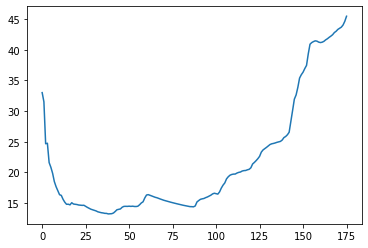

In [5]:
import matplotlib.pyplot as plt

plt.plot(scores)
plt.show()

In [6]:
agent.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 48)                1200      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 98        
Total params: 1,418
Trainable params: 1,418
Non-trainable params: 0
_________________________________________________________________


In [7]:
agent.env.close()